In [1]:
import torch
import torch.nn.functional as F

from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
import torch

# Set TORCH_LOGS and TORCHDYNAMO_VERBOSE
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

# Suppress errors and fallback to eager execution
import torch._dynamo
torch._dynamo.config.suppress_errors = True

Here, we train a MLP Layer for next word prediction. The MLP is trained with a corpus of text. The dataset is formed by splitting the text into a list of "block size" characters, with ground truth being the next character. Embedding Layer at the first stage is used to convert the input into embeddings that the architecture can handle. Post processing through layers, vocublary layer determines the next character. The size of vocublary can be chosen manually, depending on the set of characters used in the corpus. 

Tuning knobs:
1. Embedding size
2. MLP
3. Context length

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define the Text_Generator class, inheriting from nn.Module
class Text_Generator(nn.Module):
    def __init__(self, words, block_size, emb_dim, num_layers, hidden_size, epochs, seed):
        # Initialize the parent class (nn.Module)
        super().__init__()
        
        # Save the input parameters
        self.words = words
        self.epochs = epochs
        self.seed = seed

        # Get unique characters in the input words and assign integer indices (stoi)
        self.chars = sorted(list(set(''.join(words))))
        self.stoi = {s:i for i, s in enumerate(self.chars)}  # string to index
        self.itos = {i:s for s, i in self.stoi.items()}      # index to string
        self.vocab_size = len(self.itos)                     # vocabulary size

        # Define block size (sequence length) and model architecture parameters
        self.block_size = block_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.X = []  # input sequences
        self.Y = []  # target output characters

        # Define embedding dimension and create embedding layer
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(self.vocab_size, self.emb_dim)

        # Define layers of the neural network
        self.layers = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size) for _ in range(self.num_layers)])
        self.lin1 = nn.Linear(self.block_size * self.emb_dim, self.hidden_size)  # First linear layer
        self.lin2 = nn.Linear(self.hidden_size, self.vocab_size)  # Output layer (predict next character)

        # Choose device (GPU if available, else CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)  # Move the model to the selected device

        self.train_time = 0  # To track training time

    def create_data(self):
        """
        Creates the input (X) and output (Y) training data from the list of words.
        """
        for w in self.words:
            context = [0] * self.block_size  # Start with a context of 0s (padding)
            for ch in w + '.':  # Append a '.' at the end of each word
                ix = self.stoi[ch]  # Convert character to index
                self.X.append(context)  # Add current context to X
                self.Y.append(ix)  # The next character is the target output Y
                context = context[1:] + [ix]  # Shift context window to the right

        # Convert X and Y to torch tensors and move to device
        self.X = torch.tensor(self.X).to(self.device)
        self.Y = torch.tensor(self.Y).to(self.device)
        

    def plot_emb_2d(self, n_components=2):
        """
        Visualizes the embeddings of the characters in 2D using t-SNE.
        Vowels, consonants, and punctuation are plotted with different colors.
        """
        tsne = TSNE(n_components)  # Initialize t-SNE for dimensionality reduction
        emb_2d = tsne.fit_transform(self.emb.weight.cpu().detach().numpy())  # Apply t-SNE to embeddings

        # Create plot
        fig, ax = plt.subplots()
        for i in range(len(self.itos)):
            x, y = emb_2d[i]
            if self.itos[i] in 'aeiou': color = 'r'  # Vowels are red
            elif self.itos[i] in 'AEIOU': color = 'b'  # Uppercase vowels are blue
            elif self.itos[i] in 'bcdfghjklmnpqrstvwxyz': color = 'g'  # Lowercase consonants are green
            elif self.itos[i] in 'BCDFGHJKLMNPQRSTVWXYZ': color = 'orange'  # Uppercase consonants are orange
            else: color = 'k'  # Punctuation or other characters are black
            ax.scatter(x, y, color=color)
            ax.text(x + 0.05, y + 0.05, self.itos[i])  # Annotate each point with the corresponding character
           
            
        return ax

    def forward(self, x):
        """
        Defines the forward pass of the network. 
        Embeds the input, applies linear layers with activation, and predicts the next character.
        """
        x = self.emb(x)  # Convert indices to embeddings
        x = x.view(x.shape[0], -1)  # Flatten the embeddings
        x = self.lin1(x)  # Pass through the first linear layer
        for layer in self.layers:
            x = torch.sigmoid(layer(x))  # Apply sine activation and pass through hidden layers
        x = self.lin2(x)  # Output layer (predict next character)
        return x

    def generate_text(self, input_string, max_len):
        """
        Generates a new word based on an input string and the model's predictions.
        """
        g = torch.Generator()
        g.manual_seed(self.seed)  # Set random seed for reproducibility

        # Convert the input string to indices using stoi (character to index)
        context = [self.stoi.get(ch, 0) for ch in input_string][-self.block_size:]  # Seed context with input_string
        context = [0] * (self.block_size - len(context)) + context  # Zero-pad if input_string is shorter than block_size

        name = input_string  # Start the name with the input string

        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(self.device)  # Prepare input context
            y_pred = self.forward(x)  # Get model predictions
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample next character
            ch = self.itos[ix]  # Convert index to character

            name += ch  # Append predicted character to the name
            context = context[1:] + [ix]  # Update context by shifting and adding the new character

        return name


    def parameter_details(self):
        """
        Prints details (names and shapes) of all the model parameters.
        """
        for param_name, param in self.named_parameters():
            print(param_name, param.shape)

    def train(self):
        """
        Trains the model using CrossEntropyLoss and AdamW optimizer. Implements mini-batch training.
        """
        # Define loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()
        opt = optim.AdamW(self.parameters(), lr=0.001)

        # Training configuration
        batch_size = 4096
        print_every = 10

        # Measure training time
        start_time = time.time()

        # Training loop
        for epoch in range(self.epochs):
            for i in range(0, self.X.shape[0], batch_size):
                x = self.X[i:i + batch_size]  # Get a batch of input data
                y = self.Y[i:i + batch_size]  # Get the corresponding targets
                y_pred = self.forward(x)  # Forward pass
                loss = loss_fn(y_pred, y)  # Compute the loss

                # Backpropagation
                loss.backward()
                opt.step()
                opt.zero_grad()  # Clear gradients for next iteration

            # Print loss every few epochs
            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Calculate total training time
        end_time = time.time()
        self.train_time = end_time - start_time

In [11]:
import urllib.request
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# Download the file
response = urllib.request.urlopen(url)
shakespeare_text = response.read().decode("utf-8")
words = shakespeare_text.split('\n\n',800)[:-1]

In [12]:
block_size = 4 ; emb_dim = 10 ; layers = 5 ; hidden_size = 512 ; seed = 400000
A = Text_Generator(words,block_size,emb_dim,layers,hidden_size,epochs = 100,seed = seed)
A.create_data() 
A.train()

Epoch 0, Loss: 3.3009848594665527
Epoch 10, Loss: 2.5136330127716064
Epoch 20, Loss: 2.2681257724761963
Epoch 30, Loss: 2.037324905395508
Epoch 40, Loss: 1.905700922012329
Epoch 50, Loss: 1.7996468544006348
Epoch 60, Loss: 1.7283105850219727
Epoch 70, Loss: 1.7094358205795288
Epoch 80, Loss: 1.6277830600738525
Epoch 90, Loss: 1.6741514205932617


In [13]:
print(A.generate_text("Hello",100))

Hellow, no aatewere my ay made wip, peaqon grave gods, bugeson,
Youd k; Tofes coseat show their poward:.



<Axes: >

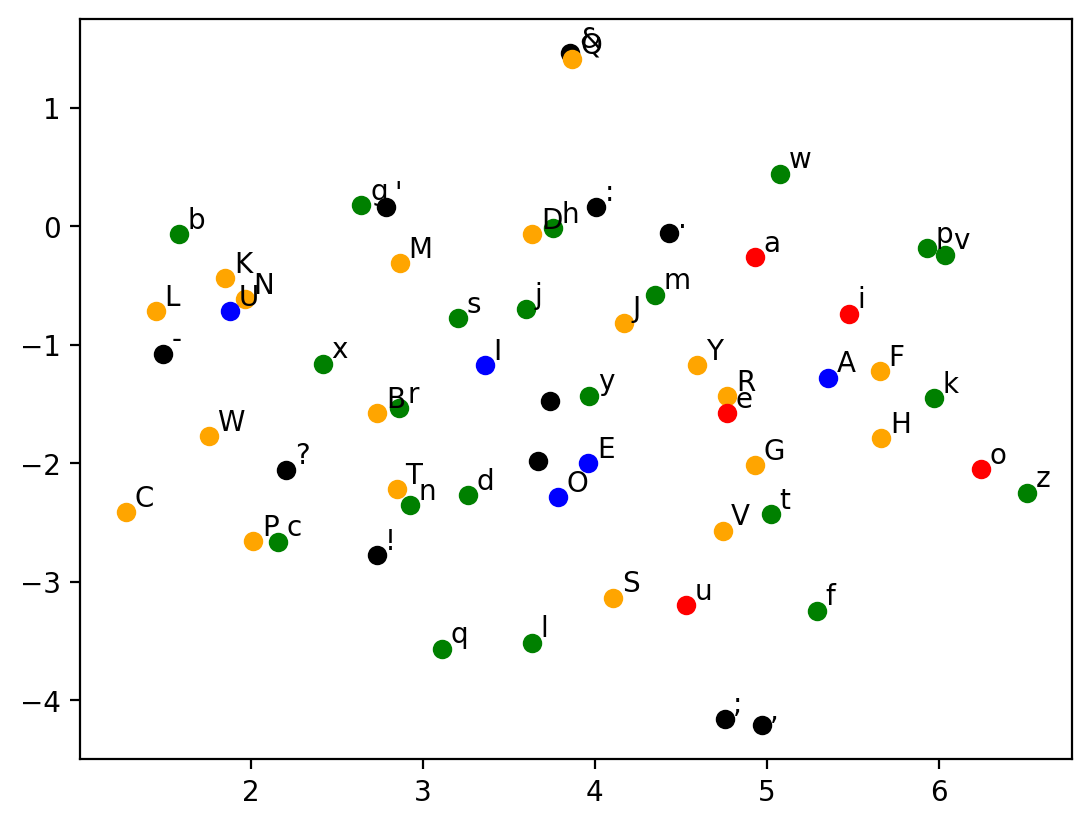

In [14]:
A.plot_emb_2d()